<a href="https://colab.research.google.com/github/AleksaNady/-1/blob/main/course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course project


**Основное**
- Дедлайн - 10 июня 23:59
- Целевая метрика precision@5
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. В решении должны быть отчетливо видна метрика на новом тестовом сете из файла retail_test1.csv, то есть вам нужно для всех юзеров из этого файла выдать выши рекомендации, и посчитать на actual покупках precision@5. 

**!! Мы не рассматриваем холодный старт для пользователя, все наши пользователя одинаковы во всех сетах, поэтому нужно позаботиться об их исключении из теста.**


**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 

# Import libs

In [ ]:
!pip install cornac

In [ ]:
!pip install torch

In [ ]:
!pip install vaex

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import vaex as vx
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

import seaborn as sns
import matplotlib.pyplot as plt

# Модель второго уровня
from lightgbm import LGBMClassifier, LGBMRanker
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender
import cornac
import torch

from scipy.sparse import csr_matrix
from sklearn import preprocessing
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from sklearn.preprocessing import OneHotEncoder

INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


Привет Виктор! Курсовой посмотрел, все ок, но есть замечания и пункт по скору:
1) Когда делаете предикт для теста берите весь датасет из прошлого!
2) Получите лучший скор с первого этапа, и дальше добивайте ранжированием
3)Создавайте больше парных фичей юзер-товар

## Read data

In [ ]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# Set global const

In [ ]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 50

# Process features dataset

In [ ]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [ ]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [ ]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [ ]:
len(item_features['sub_commodity_desc'].unique())

2383

In [ ]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [ ]:
user_features['age'] = user_features['age_desc'].str[:2].astype('int32')

In [ ]:
user_features['income_desc'].unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [ ]:
data['delta_dt_week'] = np.max(data['week_no']) - data['week_no']
data['visits'] = 1
data['sum_price'] = data['sales_value'] * data['quantity']
data['delta_dt_day'] = np.max(data['day']) - data['day']

In [ ]:
data = data.merge(data.merge(user_features, left_on='user_id', right_on='user_id').groupby('item_id').agg('age').mean().rename('mean_age'), left_on='item_id', right_on='item_id')

In [ ]:
user_features['income'] = user_features['income_desc'].str.split('K').str[0].str.split('-').str[0].str.replace('Under', '', regex=False)
user_features['income'] = user_features['income'].astype('int32')

In [ ]:
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,delta_dt_week,visits,sum_price,delta_dt_day,mean_age
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,94,1,1.39,662,39.352742
1,1929,27021022215,4,1004906,1,1.39,441,-0.6,1755,1,0.0,0.0,94,1,1.39,659,39.352742
2,568,27021090189,4,1004906,1,1.39,446,-0.6,35,1,0.0,0.0,94,1,1.39,659,39.352742
3,887,27031467254,5,1004906,1,1.39,298,-0.6,1551,1,0.0,0.0,94,1,1.39,658,39.352742
4,175,27057508267,7,1004906,1,1.99,446,0.0,2303,2,0.0,0.0,93,1,1.99,656,39.352742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362834,2364,41655180249,663,10461632,1,7.19,673,-0.8,1122,95,0.0,0.0,0,1,7.19,0,45.000000
2362835,2364,41655180249,663,17181780,1,1.59,673,0.0,1122,95,0.0,0.0,0,1,1.59,0,45.000000
2362836,1001,41655829421,663,13217063,1,1.69,3131,0.0,2231,95,0.0,0.0,0,1,1.69,0,45.000000
2362837,1001,41655829421,663,13217800,1,1.69,3131,0.0,2231,95,0.0,0.0,0,1,1.69,0,45.000000


In [ ]:
data = data.merge(data.merge(user_features, left_on='user_id', right_on='user_id').groupby('item_id').agg('income').mean().rename('mean_income'), left_on='item_id', right_on='item_id')

In [ ]:
item_features = item_features.merge(data.merge(item_features, left_on='item_id', right_on='item_id').groupby('department').agg('department').count().rename('count_department'), left_on='department', right_on='department')

In [ ]:
item_features = item_features.merge(data.merge(item_features, left_on='item_id', right_on='item_id').groupby('department').agg('sum_price').mean().rename('mean_department_sum_price'), left_on='department', right_on='department')

In [ ]:
item_features = item_features.merge(data.merge(item_features, left_on='item_id', right_on='item_id').groupby('brand').agg('sum_price').mean().rename('mean_brand_sum_price'), left_on='brand', right_on='brand')

In [ ]:
item_features = item_features.merge(data.merge(item_features, left_on='item_id', right_on='item_id').groupby('manufacturer').agg('sum_price').mean().rename('mean_manufacturer_sum_price'), left_on='manufacturer', right_on='manufacturer')

In [ ]:
item_features = item_features.merge(data.merge(item_features, left_on='item_id', right_on='item_id').groupby('brand').agg('sum_price').count().rename('count_brand'), left_on='brand', right_on='brand')

In [ ]:
item_features = item_features.merge(data.merge(item_features, left_on='item_id', right_on='item_id').groupby('manufacturer').agg('sum_price').count().rename('count_manufacturer'), left_on='manufacturer', right_on='manufacturer')

In [ ]:
user_item = user_features.merge(data.merge(item_features, left_on='item_id', right_on='item_id'), left_on='user_id', right_on='user_id')
user_item

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age,income,...,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,count_department,mean_department_sum_price,mean_brand_sum_price,mean_manufacturer_sum_price,count_brand,count_manufacturer
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,65,35,...,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,237021,2.986897,11074.865385,11286.242913,683451,670644
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,65,35,...,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,237021,2.986897,11074.865385,11286.242913,683451,670644
2,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,65,35,...,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,237021,2.986897,11074.865385,11286.242913,683451,670644
3,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,65,35,...,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,237021,2.986897,11074.865385,11286.242913,683451,670644
4,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,65,35,...,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,237021,2.986897,11074.865385,11286.242913,683451,670644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318107,25-34,U,Under 15K,Unknown,2 Adults Kids,3,1,2499,25,15,...,National,REFRGRATD DOUGH PRODUCTS,REFRIGERATED COOKIES-SEASONAL,16 OZ,1503017,3.901147,4.728807,5.237200,1679388,14314
1318108,25-34,U,Under 15K,Unknown,2 Adults Kids,3,1,2499,25,15,...,National,AUDIO/VIDEO PRODUCTS,SPHE DVDS,,246423,5.397013,4.728807,10.111282,1679388,117
1318109,25-34,U,Under 15K,Unknown,2 Adults Kids,3,1,2499,25,15,...,National,COLD AND FLU,VAPORIZERS,3 CT,246423,5.397013,4.728807,5.769298,1679388,413
1318110,25-34,U,Under 15K,Unknown,2 Adults Kids,3,1,2499,25,15,...,National,EYE AND EAR CARE PRODUCTS,SOFT LENS - NON CHEMICAL,,246423,5.397013,4.728807,8.823467,1679388,75


In [ ]:
data = data.merge(user_item.groupby('user_id').agg('mean_department_sum_price').mean().rename('mean_department_sum_price_byuser'), left_on='user_id', right_on='user_id')

In [ ]:
data = data.merge(user_item.groupby('user_id').agg('mean_brand_sum_price').mean().rename('mean_brand_sum_price_byuser'), left_on='user_id', right_on='user_id')

In [ ]:
#data = data.merge(item_features.merge(user_item.groupby('commodity_desc').agg('age').mean().rename('commodity_meen_age'), left_on='commodity_desc', right_on='commodity_desc')[['item_id', 'commodity_meen_age']], left_on='item_id', right_on='item_id')

In [ ]:
data = data.merge(item_features[['item_id','count_manufacturer', 'count_brand', 'mean_manufacturer_sum_price', 'mean_brand_sum_price', 'mean_department_sum_price', 'count_department' ]], left_on='item_id', right_on='item_id')

In [ ]:
#data = data.merge(user_features, left_on='user_id', right_on='user_id')
#data = data.merge(item_features, left_on='item_id', right_on='item_id')

In [ ]:
data['day_week'] = data['day'] % 7 + 1
data['day_month'] = data['day'] % 30 + 1
data['year'] =  ((data['day'] % 365) / 200).astype('int32') + 1
data['quartal'] = (((data['day'] % 80)/ 10 + 1).astype('int32') / data['year']).astype('int32')

In [ ]:
data['year'].unique()

array([1, 2])

In [ ]:
data['quartal'].unique()

array([1, 6, 2, 3, 5, 4, 7, 8, 0])

In [ ]:
sum_day_week = data.groupby('day_week').sum_price.agg(sum_sale_day_week  = 'sum',)
sum_day_week['sum_sale_day_week'] = sum_day_week['sum_sale_day_week'] / max(sum_day_week['sum_sale_day_week'])
data = data.merge(sum_day_week, left_on='day_week', right_on='day_week', right_index=True)

sum_day_week = data.groupby('day_month').sum_price.agg(sum_sale_day_month  = 'sum',)
sum_day_week['sum_sale_day_month'] = sum_day_week['sum_sale_day_month'] / max(sum_day_week['sum_sale_day_month'])
data = data.merge(sum_day_week, left_on='day_month', right_on='day_month', right_index=True)

sum_day_week = data.groupby('quartal').sum_price.agg(sum_sale_quartal  = 'sum',)
sum_day_week['sum_sale_quartal'] = sum_day_week['sum_sale_quartal'] / max(sum_day_week['sum_sale_quartal'])
data = data.merge(sum_day_week, left_on='quartal', right_on='quartal', right_index=True)

sum_day_week = data.groupby('day_week').quantity.agg(sum_quantity_day_week  = 'sum',)
sum_day_week['sum_quantity_day_week'] = sum_day_week['sum_quantity_day_week'] / max(sum_day_week['sum_quantity_day_week'])
data = data.merge(sum_day_week, left_on='day_week', right_on='day_week', right_index=True)

sum_day_week = data.groupby('day_month').quantity.agg(sum_quantity_day_month  = 'sum',)
sum_day_week['sum_quantity_day_month'] = sum_day_week['sum_quantity_day_month'] / max(sum_day_week['sum_quantity_day_month'])
data = data.merge(sum_day_week, left_on='day_month', right_on='day_month', right_index=True)

sum_day_week = data.groupby('quartal').quantity.agg(sum_quantity_quartal  = 'sum',)
sum_day_week['sum_quantity_quartal'] = sum_day_week['sum_quantity_quartal'] / max(sum_day_week['sum_quantity_quartal'])
data = data.merge(sum_day_week, left_on='quartal', right_on='quartal', right_index=True)

data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,day_week,day_month,year,quartal,sum_sale_day_week,sum_sale_day_month,sum_sale_quartal,sum_quantity_day_week,sum_quantity_day_month,sum_quantity_quartal
0,1929,27021022215,4,1004906,1,1.39,441,-0.6,1755,1,...,5,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000
3386,2018,27021557072,4,1082185,1,2.13,402,0.0,1357,1,...,5,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000
5242,361,27021420778,4,1082185,1,0.97,443,0.0,1103,1,...,5,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000
16032,630,27021451838,4,1082185,1,1.17,306,0.0,1341,1,...,5,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000
22162,1929,27021022215,4,981760,2,1.58,441,-1.2,1755,1,...,5,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317928,2364,40327936061,569,1889868,1,2.35,673,0.0,1736,82,...,3,30,2,0,0.998660,0.765284,0.262883,1.000000,0.806121,0.294885
1317929,2364,40327936061,569,1979140,1,0.67,673,0.0,1736,82,...,3,30,2,0,0.998660,0.765284,0.262883,1.000000,0.806121,0.294885
1317930,2364,40327936061,569,2008764,1,3.28,673,0.0,1736,82,...,3,30,2,0,0.998660,0.765284,0.262883,1.000000,0.806121,0.294885
1317932,2364,40327936061,569,8163350,2,59.98,673,0.0,1736,82,...,3,30,2,0,0.998660,0.765284,0.262883,1.000000,0.806121,0.294885


# Split dataset for train, eval, test

In [ ]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 9
VAL_RANKER_WEEKS = 6

In [ ]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [ ]:
# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [ ]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [ ]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (1061355, 36) Users: 801 Items: 59399
val_matcher
Shape: (142676, 36) Users: 801 Items: 25410
train_ranker
Shape: (142676, 36) Users: 801 Items: 25410
val_ranker
Shape: (114081, 36) Users: 789 Items: 23414


In [ ]:
# выше видим разброс по пользователям и товарам и дальше мы перейдем к warm-start (только известные пользователи)

In [ ]:
data_val_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,day_week,day_month,year,quartal,sum_sale_day_week,sum_sale_day_month,sum_sale_quartal,sum_quantity_day_week,sum_quantity_day_month,sum_quantity_quartal
110,149,40387230589,574,1004906,1,2.99,327,0.0,1220,83,...,1,5,2,1,0.861084,0.738477,1.0,0.879845,0.80611,1.0
1336,317,40387412477,574,1004906,1,2.99,356,0.0,1820,83,...,1,5,2,1,0.861084,0.738477,1.0,0.879845,0.80611,1.0


# Prefilter items

In [ ]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=1200)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

d:\git\GB-Рекомендательные системы\Курсовой\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 59399 to 1201


In [ ]:
data_train_matcher

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,day_month,year,quartal,sum_sale_day_week,sum_sale_day_month,sum_sale_quartal,sum_quantity_day_week,sum_quantity_day_month,sum_quantity_quartal,price
3386,2018,27021557072,4,1082185,1,2.13,402,0.00,1357,1,...,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000,2.13
29767,1929,27021022215,4,1106523,1,2.49,441,0.00,1755,1,...,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000,2.49
29861,2018,27021557072,4,1106523,1,2.49,402,0.00,1357,1,...,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000,2.49
30498,361,27021420778,4,1106523,1,2.49,443,0.00,1103,1,...,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000,2.49
44368,1929,27021022215,4,999999,1,2.69,441,0.00,1755,1,...,5,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.000000,2.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317409,2364,31886101364,329,999999,1,4.79,673,-0.99,1737,48,...,30,2,0,0.861084,0.765284,0.262883,0.879845,0.806121,0.294885,4.79
1317411,2364,31886101364,329,999999,1,3.52,673,0.00,1737,48,...,30,2,0,0.861084,0.765284,0.262883,0.879845,0.806121,0.294885,3.52
1317413,2364,31886101364,329,999999,1,2.50,673,-0.78,1737,48,...,30,2,0,0.861084,0.765284,0.262883,0.879845,0.806121,0.294885,2.50
1317414,2364,31886101364,329,999999,1,3.00,673,-0.50,1737,48,...,30,2,0,0.861084,0.765284,0.262883,0.879845,0.806121,0.294885,3.00


In [ ]:
def prefilter_items_(data, take_n_popular=5000):
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity_visits = data.groupby('item_id')['visits'].sum().reset_index()
    popularity_sum_price = data.groupby('item_id')['sum_price'].sum().reset_index()

    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    print(popularity.columns)
    popularity['n_sold'] = popularity['n_sold'] / np.max(popularity['n_sold'])
    popularity_visits['visits'] = popularity_visits['visits'] / np.max(popularity_visits['visits'])
    popularity_sum_price['sum_price'] = popularity_sum_price['sum_price'] / np.max(popularity_sum_price['sum_price'])

    popularity['n_sold'] = popularity['n_sold'] * popularity_visits['visits'] * popularity_sum_price['sum_price']
    
    
    popularity['n_sold'] = popularity['n_sold'] / np.max(popularity['n_sold'])
    popularity = popularity.sort_values('n_sold', ascending=False)    

    return popularity.head(take_n_popular), popularity

In [ ]:
popularity_, popularity  = prefilter_items_(data_train_matcher, take_n_popular=1200)
popularity_

Index(['item_id', 'n_sold'], dtype='object')


,item_id,n_sold
518,999999,1.000000e+00
607,1029743,4.261836e-06
949,5569230,1.738226e-06
296,916122,1.492410e-06
822,1106523,8.858333e-07
...,...,...
874,1127470,8.239437e-12
559,1014458,8.208640e-12
346,934948,8.163344e-12
1119,9553048,8.087597e-12


In [ ]:
data_train_matcher = data_train_matcher.merge(popularity_, left_on='item_id', right_on='item_id')

In [ ]:
data_val_matcher = data_val_matcher.merge(popularity_, left_on='item_id', right_on='item_id')

# Make cold-start to warm-start

In [ ]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

# оставляем общих пользователей
data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (434538, 38) Users: 779 Items: 1200
val_matcher
Shape: (29280, 37) Users: 779 Items: 1124
train_ranker
Shape: (141589, 36) Users: 779 Items: 25053
val_ranker
Shape: (113659, 36) Users: 779 Items: 23171


# Init/train recommender

In [ ]:
data_train_matcher

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,year,quartal,sum_sale_day_week,sum_sale_day_month,sum_sale_quartal,sum_quantity_day_week,sum_quantity_day_month,sum_quantity_quartal,price,n_sold
0,2018,27021557072,4,1082185,1,2.13,402,0.0,1357,1,...,1,1,0.870154,0.738477,1.000000,0.904472,0.806110,1.00000,2.13,4.114753e-10
1,1982,31944643744,334,1082185,1,2.24,319,0.0,2131,48,...,2,1,0.801968,0.738477,1.000000,0.833034,0.806110,1.00000,2.24,4.114753e-10
2,22,34227065913,488,1082185,1,2.03,365,0.0,1201,70,...,1,1,0.801968,0.758426,1.000000,0.833034,0.796419,1.00000,2.03,4.114753e-10
3,1879,34226776443,488,1082185,1,2.30,315,0.0,1556,70,...,1,1,0.801968,0.758426,1.000000,0.833034,0.796419,1.00000,2.30,4.114753e-10
4,696,29182888345,166,1082185,1,2.09,31742,0.0,2039,24,...,1,1,0.801968,0.804019,1.000000,0.833034,0.821121,1.00000,2.09,4.114753e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441975,1864,28771727723,139,7024990,1,2.50,380,0.0,1802,21,...,1,6,0.919133,0.788590,0.381737,0.922370,0.816346,0.36305,2.50,1.789745e-10
441976,1944,28675685878,134,7024990,1,2.50,361,0.0,1111,20,...,1,6,0.887010,0.770793,0.381737,0.901224,0.811186,0.36305,2.50,1.789745e-10
441977,856,28675605197,134,7024990,1,2.50,372,0.0,2229,20,...,1,6,0.887010,0.770793,0.381737,0.901224,0.811186,0.36305,2.50,1.789745e-10
441978,462,28675677650,134,7024990,1,2.50,432,0.0,2014,20,...,1,6,0.887010,0.770793,0.381737,0.901224,0.811186,0.36305,2.50,1.789745e-10


In [ ]:
recommender = MainRecommender(data_train_matcher)

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# Default column names
DEFAULT_USER_COL = "userID"
DEFAULT_ITEM_COL = "itemID"
DEFAULT_RATING_COL = "rating"
DEFAULT_LABEL_COL = "label"
DEFAULT_TIMESTAMP_COL = "timestamp"
DEFAULT_PREDICTION_COL = "prediction"
COL_DICT = {
    "col_user": DEFAULT_USER_COL,
    "col_item": DEFAULT_ITEM_COL,
    "col_rating": DEFAULT_RATING_COL,
    "col_prediction": DEFAULT_PREDICTION_COL,
}

# Filtering variables
DEFAULT_K = 10
DEFAULT_THRESHOLD = 10

# Other
SEED = 42

In [ ]:
try:
    from pyspark.sql import functions as F, Window
except ImportError:
    pass  # so the environment without spark doesn't break


def process_split_ratio(ratio):
    """Generate split ratio lists.
    Args:
        ratio (float or list): a float number that indicates split ratio or a list of float
        numbers that indicate split ratios (if it is a multi-split).
    Returns:
        tuple: a tuple containing
            bool: A boolean variable multi that indicates if the splitting is multi or single.
            list: A list of normalized split ratios.
    """
    if isinstance(ratio, float):
        if ratio <= 0 or ratio >= 1:
            raise ValueError("Split ratio has to be between 0 and 1")

        multi = False
    elif isinstance(ratio, list):
        if any([x <= 0 for x in ratio]):
            raise ValueError(
                "All split ratios in the ratio list should be larger than 0."
            )

        # normalize split ratios if they are not summed to 1
        if math.fsum(ratio) != 1.0:
            ratio = [x / math.fsum(ratio) for x in ratio]

        multi = True
    else:
        raise TypeError("Split ratio should be either float or a list of floats.")

    return multi, ratio


def min_rating_filter_pandas(
    data,
    min_rating=1,
    filter_by="user",
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
):
    """Filter rating DataFrame for each user with minimum rating.
    Filter rating data frame with minimum number of ratings for user/item is usually useful to
    generate a new data frame with warm user/item. The warmth is defined by min_rating argument. For
    example, a user is called warm if he has rated at least 4 items.
    Args:
        data (pd.DataFrame): DataFrame of user-item tuples. Columns of user and item
            should be present in the DataFrame while other columns like rating, 
            timestamp, etc. can be optional.
        min_rating (int): minimum number of ratings for user or item.
        filter_by (str): either "user" or "item", depending on which of the two is to 
            filter with min_rating.
        col_user (str): column name of user ID.
        col_item (str): column name of item ID.
    Returns:
        pd.DataFrame: DataFrame with at least columns of user and item that has been 
            filtered by the given specifications.
    """
    split_by_column = _get_column_name(
        filter_by, col_user, col_item
    )

    if min_rating < 1:
        raise ValueError("min_rating should be integer and larger than or equal to 1.")

    return (
        data
        .groupby(split_by_column)
        .filter(lambda x: len(x) >= min_rating)
    )
    


def min_rating_filter_spark(
    data,
    min_rating=1,
    filter_by="user",
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
):
    """Filter rating DataFrame for each user with minimum rating.
    Filter rating data frame with minimum number of ratings for user/item is usually useful to
    generate a new data frame with warm user/item. The warmth is defined by min_rating argument. For
    example, a user is called warm if he has rated at least 4 items.
    Args:
        data (spark.DataFrame): DataFrame of user-item tuples. Columns of user and item
            should be present in the DataFrame while other columns like rating, 
            timestamp, etc. can be optional.
        min_rating (int): minimum number of ratings for user or item.
        filter_by (str): either "user" or "item", depending on which of the two is to 
            filter with min_rating.
        col_user (str): column name of user ID.
        col_item (str): column name of item ID.
    Returns:
        spark.DataFrame: DataFrame with at least columns of user and item that has been 
            filtered by the given specifications.
    """

    split_by_column = _get_column_name(
        filter_by, col_user, col_item
    )

    if min_rating < 1:
        raise ValueError("min_rating should be integer and larger than or equal to 1.")

    if min_rating > 1:
        window = Window.partitionBy(split_by_column)
        data = (
            data
            .withColumn("_count", F.count(split_by_column).over(window))
            .where(F.col("_count") >= min_rating)
            .drop("_count")
        )
    
    return data


def _get_column_name(name, col_user, col_item):
    if name == "user":
        return col_user
    elif name == "item":
        return col_item
    else:
        raise ValueError("name should be either 'user' or 'item'.")


def split_pandas_data_with_ratios(data, ratios, seed=42, shuffle=False):
    """Helper function to split pandas DataFrame with given ratios
    .. note::
        Implementation referenced from `this source <https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test>`_.
    Args:
        data (pd.DataFrame): Pandas data frame to be split.
        ratios (list of floats): list of ratios for split. The ratios have to sum to 1.
        seed (int): random seed.
        shuffle (bool): whether data will be shuffled when being split.
    Returns:
        list: List of pd.DataFrame split by the given specifications.
    """
    if math.fsum(ratios) != 1.0:
        raise ValueError("The ratios have to sum to 1")

    split_index = np.cumsum(ratios).tolist()[:-1]

    if shuffle:
        data = data.sample(frac=1, random_state=seed)

    splits = np.split(data, [round(x * len(data)) for x in split_index])

    # Add split index (this makes splitting by group more efficient).
    for i in range(len(ratios)):
        splits[i]["split_index"] = i

    return splits

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as sk_split


def python_random_split(data, ratio=0.75, seed=42):
    """Pandas random splitter.
    The splitter randomly splits the input data.
    Args:
        data (pd.DataFrame): Pandas DataFrame to be split.
        ratio (float or list): Ratio for splitting data. If it is a single float number
            it splits data into two halves and the ratio argument indicates the ratio
            of training data set; if it is a list of float numbers, the splitter splits
            data into several portions corresponding to the split ratios. If a list is
            provided and the ratios are not summed to 1, they will be normalized.
        seed (int): Seed.
    Returns:
        list: Splits of the input data as pd.DataFrame.
    """
    multi_split, ratio = process_split_ratio(ratio)

    if multi_split:
        splits = split_pandas_data_with_ratios(data, ratio, shuffle=True, seed=seed)
        splits_new = [x.drop("split_index", axis=1) for x in splits]

        return splits_new
    else:
        return sk_split(data, test_size=None, train_size=ratio, random_state=seed)


def _do_stratification(
    data,
    ratio=0.75,
    min_rating=1,
    filter_by="user",
    is_random=True,
    seed=42,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_timestamp=DEFAULT_TIMESTAMP_COL,
):
    # A few preliminary checks.
    if not (filter_by == "user" or filter_by == "item"):
        raise ValueError("filter_by should be either 'user' or 'item'.")

    if min_rating < 1:
        raise ValueError("min_rating should be integer and larger than or equal to 1.")

    if col_user not in data.columns:
        raise ValueError("Schema of data not valid. Missing User Col")

    if col_item not in data.columns:
        raise ValueError("Schema of data not valid. Missing Item Col")

    if not is_random:
        if col_timestamp not in data.columns:
            raise ValueError("Schema of data not valid. Missing Timestamp Col")

    multi_split, ratio = process_split_ratio(ratio)

    split_by_column = col_user if filter_by == "user" else col_item

    ratio = ratio if multi_split else [ratio, 1 - ratio]

    if min_rating > 1:
        data = min_rating_filter_pandas(
            data,
            min_rating=min_rating,
            filter_by=filter_by,
            col_user=col_user,
            col_item=col_item,
        )

    # Split by each group and aggregate splits together.
    splits = []

    # If it is for chronological splitting, the split will be performed in a random way.
    df_grouped = (
        data.sort_values(col_timestamp).groupby(split_by_column)
        if is_random is False
        else data.groupby(split_by_column)
    )

    for _, group in df_grouped:
        group_splits = split_pandas_data_with_ratios(
            group, ratio, shuffle=is_random, seed=seed
        )

        # Concatenate the list of split dataframes.
        concat_group_splits = pd.concat(group_splits)

        splits.append(concat_group_splits)

    # Concatenate splits for all the groups together.
    splits_all = pd.concat(splits)

    # Take split by split_index
    splits_list = [
        splits_all[splits_all["split_index"] == x].drop("split_index", axis=1)
        for x in range(len(ratio))
    ]

    return splits_list


def python_chrono_split(
    data,
    ratio=0.75,
    min_rating=1,
    filter_by="user",
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_timestamp=DEFAULT_TIMESTAMP_COL,
):
    """Pandas chronological splitter.
    This function splits data in a chronological manner. That is, for each user / item, the
    split function takes proportions of ratings which is specified by the split ratio(s).
    The split is stratified.
    Args:
        data (pd.DataFrame): Pandas DataFrame to be split.
        ratio (float or list): Ratio for splitting data. If it is a single float number
            it splits data into two halves and the ratio argument indicates the ratio of
            training data set; if it is a list of float numbers, the splitter splits
            data into several portions corresponding to the split ratios. If a list is
            provided and the ratios are not summed to 1, they will be normalized.
        seed (int): Seed.
        min_rating (int): minimum number of ratings for user or item.
        filter_by (str): either "user" or "item", depending on which of the two is to
            filter with min_rating.
        col_user (str): column name of user IDs.
        col_item (str): column name of item IDs.
        col_timestamp (str): column name of timestamps.
    Returns:
        list: Splits of the input data as pd.DataFrame.
    """
    return _do_stratification(
        data,
        ratio=ratio,
        min_rating=min_rating,
        filter_by=filter_by,
        col_user=col_user,
        col_item=col_item,
        col_timestamp=col_timestamp,
        is_random=False,
    )


def python_stratified_split(
    data,
    ratio=0.75,
    min_rating=1,
    filter_by="user",
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    seed=42,
):
    """Pandas stratified splitter.
    For each user / item, the split function takes proportions of ratings which is
    specified by the split ratio(s). The split is stratified.
    Args:
        data (pd.DataFrame): Pandas DataFrame to be split.
        ratio (float or list): Ratio for splitting data. If it is a single float number
            it splits data into two halves and the ratio argument indicates the ratio of
            training data set; if it is a list of float numbers, the splitter splits
            data into several portions corresponding to the split ratios. If a list is
            provided and the ratios are not summed to 1, they will be normalized.
        seed (int): Seed.
        min_rating (int): minimum number of ratings for user or item.
        filter_by (str): either "user" or "item", depending on which of the two is to
            filter with min_rating.
        col_user (str): column name of user IDs.
        col_item (str): column name of item IDs.
    Returns:
        list: Splits of the input data as pd.DataFrame.
    """
    return _do_stratification(
        data,
        ratio=ratio,
        min_rating=min_rating,
        filter_by=filter_by,
        col_user=col_user,
        col_item=col_item,
        is_random=True,
        seed=seed,
    )


def numpy_stratified_split(X, ratio=0.75, seed=42):
    """Split the user/item affinity matrix (sparse matrix) into train and test set matrices while maintaining
    local (i.e. per user) ratios.
    Main points :
    1. In a typical recommender problem, different users rate a different number of items,
    and therefore the user/affinity matrix has a sparse structure with variable number
    of zeroes (unrated items) per row (user). Cutting a total amount of ratings will
    result in a non-homogeneous distribution between train and test set, i.e. some test
    users may have many ratings while other very little if none.
    2. In an unsupervised learning problem, no explicit answer is given. For this reason
    the split needs to be implemented in a different way then in supervised learningself.
    In the latter, one typically split the dataset by rows (by examples), ending up with
    the same number of features but different number of examples in the train/test setself.
    This scheme does not work in the unsupervised case, as part of the rated items needs to
    be used as a test set for fixed number of users.
    Solution:
    1. Instead of cutting a total percentage, for each user we cut a relative ratio of the rated
    items. For example, if user1 has rated 4 items and user2 10, cutting 25% will correspond to
    1 and 2.6 ratings in the test set, approximated as 1 and 3 according to the round() function.
    In this way, the 0.75 ratio is satisfied both locally and globally, preserving the original
    distribution of ratings across the train and test set.
    2. It is easy (and fast) to satisfy this requirements by creating the test via element subtraction
    from the original dataset X. We first create two copies of X; for each user we select a random
    sample of local size ratio (point 1) and erase the remaining ratings, obtaining in this way the
    train set matrix Xtst. The train set matrix is obtained in the opposite way.
    Args:
        X (np.array, int): a sparse matrix to be split
        ratio (float): fraction of the entire dataset to constitute the train set
        seed (int): random seed
    Returns:
        np.array, np.array: Xtr is the train set user/item affinity matrix. Xtst is the test set user/item affinity
            matrix.
    """

    np.random.seed(seed)  # set the random seed
    test_cut = int((1 - ratio) * 100)  # percentage of ratings to go in the test set

    # initialize train and test set matrices
    Xtr = X.copy()
    Xtst = X.copy()

    # find the number of rated movies per user
    rated = np.sum(Xtr != 0, axis=1)

    # for each user, cut down a test_size% for the test set
    tst = np.around((rated * test_cut) / 100).astype(int)

    for u in range(X.shape[0]):
        # For each user obtain the index of rated movies
        idx = np.asarray(np.where(Xtr[u] != 0))[0].tolist()

        # extract a random subset of size n from the set of rated movies without repetition
        idx_tst = np.random.choice(idx, tst[u], replace=False)
        idx_train = list(set(idx).difference(set(idx_tst)))

        # change the selected rated movies to unrated in the train set
        Xtr[u, idx_tst] = 0
        # set the movies that appear already in the train set as 0
        Xtst[u, idx_train] = 0

    del idx, idx_train, idx_tst

    return Xtr, Xtst

In [ ]:
def predict(
    model,
    data,
    usercol=DEFAULT_USER_COL,
    itemcol=DEFAULT_ITEM_COL,
    predcol=DEFAULT_PREDICTION_COL,
):
    """Computes predictions of a recommender model from Cornac on the data.
    Can be used for computing rating metrics like RMSE.
    Args:
        model (cornac.models.Recommender): a recommender model from Cornac
        data (pd.DataFrame): the data on which to predict
        usercol (str): name of the user column
        itemcol (str): name of the item column
    Returns:
        pd.DataFrame: dataframe with usercol, itemcol, predcol
    """
    uid_map = model.train_set.uid_map
    iid_map = model.train_set.iid_map
    predictions = [
        [
            getattr(row, usercol),
            getattr(row, itemcol),
            model.rate(
                user_idx=uid_map.get(getattr(row, usercol), len(uid_map)),
                item_idx=iid_map.get(getattr(row, itemcol), len(iid_map)),
            ),
        ]
        for row in data.itertuples()
    ]
    predictions = vx.DataFrame(data=predictions, columns=[usercol, itemcol, predcol])
    return predictions


def predict_ranking(
    model,
    data,
    usercol=DEFAULT_USER_COL,
    itemcol=DEFAULT_ITEM_COL,
    predcol=DEFAULT_PREDICTION_COL,
    remove_seen=False,
    top_k=5
):
    """Computes predictions of recommender model from Cornac on all users and items in data.
    It can be used for computing ranking metrics like NDCG.
    Args:
        model (cornac.models.Recommender): a recommender model from Cornac
        data (pd.DataFrame): the data from which to get the users and items
        usercol (str): name of the user column
        itemcol (str): name of the item column
        remove_seen (bool): flag to remove (user, item) pairs seen in the training data
    Returns:
        pd.DataFrame: dataframe with usercol, itemcol, predcol
    """
    users, items, preds = [], [], []
    item = list(model.train_set.iid_map.keys())
    for uid, user_idx in model.train_set.uid_map.items():
        user = [uid] * len(item)
        scor = np.array(model.score(user_idx).tolist())
        idx = np.sort(scor)[-top_k:]
        idx_mask = [e in idx for e in scor]
        users.extend(np.array(user)[idx_mask])
        items.extend(np.array(item)[idx_mask])
        preds.extend(scor[idx_mask])
    all_predictions = pd.DataFrame(
        data={usercol: users, itemcol: items, predcol: preds}
    )

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions

In [ ]:
col = list(data_train_matcher.columns)
tmp1 = col[1]
col[1] = col[3]
col[3] = tmp1

In [ ]:
col

['user_id',
 'item_id',
 'day',
 'basket_id',
 'quantity',
 'sales_value',
 'store_id',
 'retail_disc',
 'trans_time',
 'week_no',
 'coupon_disc',
 'coupon_match_disc',
 'delta_dt_week',
 'visits',
 'sum_price',
 'delta_dt_day',
 'mean_age',
 'mean_income',
 'mean_department_sum_price_byuser',
 'mean_brand_sum_price_byuser',
 'count_manufacturer',
 'count_brand',
 'mean_manufacturer_sum_price',
 'mean_brand_sum_price',
 'mean_department_sum_price',
 'count_department',
 'day_week',
 'day_month',
 'year',
 'quartal',
 'sum_sale_day_week',
 'sum_sale_day_month',
 'sum_sale_quartal',
 'sum_quantity_day_week',
 'sum_quantity_day_month',
 'sum_quantity_quartal',
 'price',
 'n_sold']

In [ ]:
train, test = python_random_split(data_train_matcher[col], 0.9)

In [ ]:
train_set = cornac.data.Dataset.from_uir(data_train_matcher[col].itertuples(index=False), seed=SEED)

print('Number of users: {}'.format(train_set.num_users))
print('Number of items: {}'.format(train_set.num_items))

Number of users: 779
Number of items: 1200


C:\ProgramData\Anaconda3\lib\site-packages\cornac\data\dataset.py:361: UserWarning: 357981 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


In [ ]:
NUM_FACTORS = 300
NUM_EPOCHS = 250
bpr = cornac.models.BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=0.005,
    lambda_reg=0.001,
    verbose=True,
    seed=42
)

In [ ]:
bpr.fit(train_set)


Optimization finished!


In [ ]:
all_predictions_bpr = predict_ranking(bpr, train, usercol='user_id', itemcol='item_id', remove_seen=False, top_k=50)

In [ ]:
all_predictions = all_predictions_bpr.drop('prediction', axis=1)

In [ ]:
all_predictions_bpr = all_predictions.groupby('user_id')['item_id'].apply(list).reset_index(name='new')
all_predictions_bpr.rename(columns = {'new':'bpr'}, inplace = True)

In [ ]:
all_predictions_bpr

,user_id,bpr
0,1,"[999999, 1127831, 1029743, 986912, 944836, 866..."
1,7,"[1106523, 999999, 1127831, 857503, 834117, 102..."
2,8,"[1106523, 999999, 1029743, 986912, 866211, 104..."
3,13,"[1106523, 999999, 1127831, 1029743, 866211, 87..."
4,17,"[1106523, 999999, 1056509, 1029743, 1044078, 8..."
...,...,...
774,2494,"[999999, 1127831, 857503, 834117, 1029743, 104..."
775,2496,"[1106523, 999999, 1056509, 1115175, 1044078, 8..."
776,2497,"[1082185, 1106523, 999999, 1029743, 866211, 87..."
777,2498,"[999999, 1127831, 998119, 1115175, 1029743, 94..."


In [ ]:
## Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# top k items to recommend
TOP_K = 5

# Model parameters
LATENT_DIM = 50
ENCODER_DIMS = [100]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 500
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [ ]:
bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=3,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)

In [ ]:
#4.30 часа тренировки модели
train_set = cornac.data.Dataset.from_uir(data_train_matcher.itertuples(index=False), seed=3)
bivae.fit(train_set)

C:\ProgramData\Anaconda3\lib\site-packages\cornac\data\dataset.py:361: UserWarning: 607569 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


KeyboardInterrupt: 

In [ ]:
all_predictions_bivae = predict_ranking(bivae, data_train_matcher, usercol='user_id', itemcol='item_id', remove_seen=True, top_k=5)

NameError: name 'bivae' is not defined

In [ ]:
all_predictions_bivae = all_predictions_bivae.drop('prediction', axis=1)

NameError: name 'all_predictions_bivae' is not defined

In [ ]:
all_predictions_bivae = all_predictions_bivae.groupby('user_id')['item_id'].apply(list).reset_index(name='new')
all_predictions_bivae.rename(columns = {'new':'bivae'}, inplace = True)

In [ ]:
all_predictions_bivae

,user_id,bivae
0,1,"[28345371421, 28537661672, 28537667353, 286293..."
1,2,"[28345371421, 28537661672, 28537667353, 286293..."
2,3,"[28345371421, 28537661672, 28537667353, 286293..."
3,4,"[28345371421, 28537661672, 28537667353, 286293..."
4,6,"[28009427993, 28069282814, 28081312705, 281975..."
...,...,...
2082,2496,"[28345371421, 28537661672, 28537667353, 286293..."
2083,2497,"[28009427993, 28069282814, 28081312705, 281975..."
2084,2498,"[28009427993, 28069282814, 28081312705, 281975..."
2085,2499,"[28345371421, 28537661672, 28537667353, 286293..."


### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [ ]:
# Берем тестового юзера 2375

In [ ]:
recommender.get_als_recommendations(2375, N=5)

IndexError: index 781 is out of bounds for axis 0 with size 781

In [ ]:
recommender.get_own_recommendations(2375, N=5)

ValueError: userid is out of bounds of the user_items matrix

In [ ]:
recommender.get_similar_items_recommendation(2375, N=5)

[1029743, 1106523, 5569230, 916122, 1070820]

In [ ]:
recommender.get_similar_users_recommendation(2375, N=5)

[935578, 12731432, 899459, 950935, 7024847]

# Eval recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [ ]:
data_val_matcher

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,day_month,year,quartal,sum_sale_day_week,sum_sale_day_month,sum_sale_quartal,sum_quantity_day_week,sum_quantity_day_month,sum_quantity_quartal,n_sold
0,149,40387230589,574,1004906,1,2.99,327,0.00,1220,83,...,5,2,1,0.861084,0.738477,1.000000,0.879845,0.806110,1.000000,1.696899e-08
1,317,40387412477,574,1004906,1,2.99,356,0.00,1820,83,...,5,2,1,0.861084,0.738477,1.000000,0.879845,0.806110,1.000000,1.696899e-08
2,49,40387412485,574,1004906,1,2.99,356,0.00,1822,83,...,5,2,1,0.861084,0.738477,1.000000,0.879845,0.806110,1.000000,1.696899e-08
3,1247,40387242740,574,1004906,1,2.50,374,0.00,2019,83,...,5,2,1,0.861084,0.738477,1.000000,0.879845,0.806110,1.000000,1.696899e-08
4,1285,40387045609,574,1004906,1,2.99,334,0.00,1222,83,...,5,2,1,0.861084,0.738477,1.000000,0.879845,0.806110,1.000000,1.696899e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29393,1229,40198806564,559,845078,1,2.29,384,-0.20,1353,81,...,20,1,8,0.919133,0.788590,0.449328,0.922370,0.816346,0.411103,2.404933e-11
29394,371,40198561873,559,824758,1,3.19,427,-1.10,1646,81,...,20,1,8,0.919133,0.788590,0.449328,0.922370,0.816346,0.411103,2.355401e-10
29395,2154,40300661670,567,965267,1,4.99,438,0.00,1602,82,...,28,2,0,0.861084,0.850311,0.262883,0.879845,0.862673,0.294885,1.044257e-08
29396,955,40283526305,566,1135222,1,3.19,442,-0.80,1527,82,...,27,2,0,0.919133,0.842285,0.262883,0.922370,0.908835,0.294885,1.781669e-10


In [ ]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[1004906, 1082185, 857006, 1081177, 865456, 10..."
1,7,"[1082185, 1106523, 1126899, 993638, 898342, 98..."


In [ ]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

Wall time: 4.21 s


In [ ]:
result_eval_matcher['bpr'] = all_predictions_bpr['bpr']

In [ ]:
result_eval_matcher['bivae'] = all_predictions_bivae['bivae']

NameError: name 'all_predictions_bivae' is not defined

In [ ]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

### Пример оборачивания

In [ ]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [ ]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [ ]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [ ]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [ ]:
TOPK_RECALL = 50

In [ ]:
result_eval_matcher

,user_id,actual,own_rec,sim_item_rec,als_rec,bpr
0,1,"[1004906, 1082185, 857006, 1081177, 865456, 10...","[856942, 5577022, 9655212, 8090541, 5582712, 9...","[9655212, 1007512, 6464166, 843450, 1110111, 9...","[5569374, 885290, 856942, 9655212, 912704, 948...","[999999, 1127831, 1029743, 986912, 944836, 866..."
1,7,"[1082185, 1106523, 1126899, 993638, 898342, 98...","[1122358, 6602729, 894360, 5981267, 5590695, 8...","[1038985, 6602697, 1068719, 907631, 1040807, 1...","[1038985, 825749, 909268, 12731436, 9833277, 1...","[1106523, 999999, 1127831, 857503, 834117, 102..."
2,8,"[1082185, 965766, 1074754, 5569230, 1029743, 1...","[5577022, 829722, 10282046, 12302069, 981660, ...","[5569845, 8090513, 1068719, 823704, 12301405, ...","[965766, 844179, 916122, 1029743, 948086, 1128...","[1106523, 999999, 1029743, 986912, 866211, 104..."
3,13,"[1082185, 1068719, 1128016, 1027168, 861279, 5...","[965772, 1042942, 1038985, 862070, 898466, 102...","[999999, 1137507, 1122358, 963971, 1022053, 88...","[8177622, 1006184, 5569471, 5591170, 8090513, ...","[1106523, 999999, 1127831, 1029743, 866211, 87..."
4,17,"[1082185, 1068719, 1106523, 899624, 944486, 55...","[5568072, 5567874, 944486, 896085, 963971, 894...","[5567874, 6533362, 979707, 12301100, 1056509, ...","[12810391, 5569374, 1042942, 899624, 1056509, ...","[1106523, 999999, 1056509, 1029743, 1044078, 8..."
...,...,...,...,...,...,...
774,2494,"[1082185, 969568, 904236]","[7024847, 889509, 947201, 9297474, 5568249, 65...","[860299, 5569471, 8090513, 878996, 8015407, 90...","[9297474, 5569374, 878996, 1018007, 866211, 10...","[999999, 1127831, 857503, 834117, 1029743, 104..."
775,2496,"[1082185, 1106523, 899624, 965766, 844179, 916...","[7441210, 832678, 865511, 5591083, 916990, 105...","[985999, 5569845, 1115175, 1070702, 963971, 55...","[12810393, 844179, 1044078, 874972, 1131438, 9...","[1106523, 999999, 1056509, 1115175, 1044078, 8..."
776,2497,"[1068719, 870547, 1029743, 1070820, 1081177, 1...","[1135834, 916990, 1004436, 849202, 8090532, 10...","[865026, 6534030, 5569845, 1034176, 999999, 94...","[1081177, 1042942, 5569230, 5569471, 899624, 9...","[1082185, 1106523, 999999, 1029743, 866211, 87..."
777,2498,"[1082185, 1106523, 1082454, 1070820, 902396, 8...","[968759, 1076580, 849578, 1110031, 933354, 901...","[901062, 901062, 1001266, 9827950, 970202, 106...","[6514160, 997796, 8293447, 1013167, 995876, 10...","[999999, 1127831, 998119, 1115175, 1029743, 94..."


In [ ]:
for idx in list(result_eval_matcher[result_eval_matcher['bpr'].isnull()].index):
    result_eval_matcher['bpr'].iloc[idx] = result_eval_matcher['bpr'].iloc[0]

In [ ]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.347006255176159),
 ('bpr', 0.28286434055428594),
 ('als_rec', 0.24578629398557084),
 ('sim_item_rec', 0.17593205501565207)]

[('own_rec', 0.3089522601927975),
 ('bpr', 0.25146747082050097),
 ('als_rec', 0.22684053406776372),
 ('sim_item_rec', 0.15523376727008475)]

### Precision@5 of matching

In [ ]:
TOPK_PRECISION = 5

In [ ]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.35430038510911344),
 ('bpr', 0.19178433889602095),
 ('als_rec', 0.1586649550706042),
 ('sim_item_rec', 0.12580231065468606)]

[('own_rec', 0.34461538461538377),
 ('bpr', 0.1897435897435902),
 ('als_rec', 0.16410256410256502),
 ('sim_item_rec', 0.13282051282051363)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [ ]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [ ]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [ ]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [ ]:
df_match_candidates.head(2)

,user_id,candidates
0,149,"[6533936, 873044, 1109778, 847066, 959316, 913..."
1,317,"[862010, 12171656, 1102003, 983584, 1135834, 8..."


In [ ]:
# разворачиваем товары
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [ ]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [ ]:
df_match_candidates.head(4)

,user_id,item_id
0,149,6533936
0,149,873044
0,149,1109778
0,149,847066


### Check warm start

In [ ]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (38950, 2) Users: 779 Items: 1159


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [ ]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [ ]:
df_ranker_train.target.value_counts()

0.0    32490
1.0    11912
Name: target, dtype: int64

In [ ]:
df_ranker_train.head(2)

,user_id,item_id,target
0,149,6533936,1.0
1,149,6533936,1.0


(!) На каждого юзера 50 item_id-кандидатов

In [ ]:
df_ranker_train['target'].mean()

0.26827620377460476

![hard_choice.png](attachment:hard_choice.png)

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич
lambdarank
rank_xendcg

RMSE
QueryRMSE
YetiRank
YetiRankPairwise
PairLogit
PAirLogitPairwise

## Подготавливаем фичи для обучения модели

### Описательные фичи

In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,count_department,mean_department_sum_price,mean_brand_sum_price,mean_manufacturer_sum_price,count_brand,count_manufacturer
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1503017,3.901147,4.728807,3.238993,1679388,157084
1,27021,2,GROCERY,National,AIR CARE,AIR CARE - AEROSOLS,,1503017,3.901147,4.728807,3.238993,1679388,157084


In [ ]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age,income
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,65,35
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,45,50


In [ ]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,count_department,...,count_manufacturer,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,age,income
0,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,17571,45-54,U,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,45,35
1,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,17571,45-54,U,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,45,35


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Поведенческие фичи

##### Чтобы считать поведенческие фичи, нужно учесть все данные что были до data_val_ranker

In [ ]:
df_join_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,day_week,day_month,year,quartal,sum_sale_day_week,sum_sale_day_month,sum_sale_quartal,sum_quantity_day_week,sum_quantity_day_month,sum_quantity_quartal
0,1929,27021022215,4,1004906,1,1.39,441,-0.6,1755,1,...,5,5,1,1,0.870154,0.738477,1.0,0.904472,0.80611,1.0
3386,2018,27021557072,4,1082185,1,2.13,402,0.0,1357,1,...,5,5,1,1,0.870154,0.738477,1.0,0.904472,0.80611,1.0
5242,361,27021420778,4,1082185,1,0.97,443,0.0,1103,1,...,5,5,1,1,0.870154,0.738477,1.0,0.904472,0.80611,1.0
16032,630,27021451838,4,1082185,1,1.17,306,0.0,1341,1,...,5,5,1,1,0.870154,0.738477,1.0,0.904472,0.80611,1.0
22162,1929,27021022215,4,981760,2,1.58,441,-1.2,1755,1,...,5,5,1,1,0.870154,0.738477,1.0,0.904472,0.80611,1.0


## !!! Пока выполните нотбук без этих строк, потом вернитесь и запустите их, обучите ранкер и посмотрите на метрики с ранжированием

In [ ]:
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)
#+0.03
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)
#+0.04
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)
#-0.011
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)
#-0.08
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)
#+0.014
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sum_sale_day_week').mean().rename('mean_sales_item_week_day'), how='left',on=USER_COL)
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sum_sale_day_month').mean().rename('mean_sales_item_month_day'), how='left',on=USER_COL)
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sum_sale_quartal').mean().rename('mean_sales_item_quartal'), how='left',on=USER_COL)
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sum_quantity_day_week').mean().rename('mean_quantity_item_week_day'), how='left',on=USER_COL)
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sum_quantity_day_month').mean().rename('mean_quantity_item_month_day'), how='left',on=USER_COL)
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sum_quantity_quartal').mean().rename('mean_quantity_item_quartal'), how='left',on=USER_COL)
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.merge(user_features, left_on='user_id', right_on='user_id').groupby(by=USER_COL).agg('age_desc').max().rename('max_age'), how='left',on=USER_COL)
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.merge(user_features, left_on='user_id', right_on='user_id').groupby(by=USER_COL).agg('age_desc').min().rename('min_age'), how='left',on=USER_COL)

#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)
#0.0
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)
#-0.01
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)
#0.0
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)
#-0.01
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)
#-0.03
#df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)
#-0.015

In [ ]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,count_department,...,total_item_sales_value,total_quantity_value,item_freq,total_user_sales_value,mean_sales_item_week_day,mean_sales_item_month_day,mean_sales_item_quartal,mean_quantity_item_week_day,mean_quantity_item_month_day,mean_quantity_item_quartal
0,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.71044,0.892511,0.861405,0.685262
1,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.71044,0.892511,0.861405,0.685262
2,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.71044,0.892511,0.861405,0.685262
3,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.71044,0.892511,0.861405,0.685262
4,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.71044,0.892511,0.861405,0.685262


In [ ]:
#df_ranker_train['max_age'] = df_ranker_train['max_age'].fillna('-')
#df_ranker_train['min_age'] = df_ranker_train['min_age'].fillna('-')

In [ ]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

df_ranker_train

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,count_department,...,total_item_sales_value,total_quantity_value,item_freq,total_user_sales_value,mean_sales_item_week_day,mean_sales_item_month_day,mean_sales_item_quartal,mean_quantity_item_week_day,mean_quantity_item_month_day,mean_quantity_item_quartal
0,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
1,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
2,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
3,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
4,149,6533936,1.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44397,752,863447,0.0,2877,MEAT,National,BEEF,CHOICE BEEF,,80865,...,2855.18,484,397,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893
44398,752,862799,0.0,1046,GROCERY,National,COFFEE,GROUND COFFEE,39 OZ,1503017,...,951.99,171,157,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893
44399,752,1138443,0.0,3739,DELI,National,DELI MEATS,MEAT: TURKEY BULK,,57214,...,2168.16,453,444,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893
44400,752,1065167,0.0,4099,DELI,National,CHEESES,CHEESE: NATURAL BULK,,57214,...,343.35,104,104,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893


In [ ]:
for col in X_train.columns: 
    print(col)
    val = X_train[col].values
    print("unique")
    try:
        print(len(np.unique(val)))
        print(np.unique(val)[:5])
    except:
        print(val[:2])
        print('warning')
    print(X_train[col].dtype)
    print()

user_id
unique
779
[ 1  7  8 13 17]
int64

item_id
unique
1159
[819255 819308 819978 820301 820321]
int64

manufacturer
unique
338
[ 2  5 35 61 69]
int64

department
unique
13
['DELI' 'DRUG GM' 'FLORAL' 'GROCERY' 'MEAT']
object

brand
unique
2
['National' 'Private']
object

commodity_desc
unique
138
['APPLES' 'BACON' 'BAG SNACKS' 'BAKED BREAD/BUNS/ROLLS'
 'BAKED SWEET GOODS']
object

sub_commodity_desc
unique
380
['ADULT CEREAL' 'AEROSOL TOPPINGS' 'ALKALINE BATTERIES'
 'ALL FAMILY CEREAL' 'ALUMINUM FOIL']
object

curr_size_of_product
unique
270
[' ' '(600) 4LB' '.5 LTR' '.7 OZ' '1 DOZEN']
object

count_department
unique
13
[1705 1941 3611 3809 9947]
int64

mean_department_sum_price
unique
13
[2.98689749 3.90114737 4.31551163 4.7705226  5.21156957]
float64

mean_brand_sum_price
unique
2
[4.72880715e+00 1.10748654e+04]
float64

mean_manufacturer_sum_price
unique
338
[2.0168315  2.39275184 2.49077401 2.57231068 2.60289649]
float64

count_brand
unique
2
[ 683451 1679388]
int64

count_manuf

In [ ]:
X_train['age_desc'].unique()

array(['45-54', '35-44', '25-34', '65+', '55-64', '19-24'], dtype=object)

In [ ]:
X_train['marital_status_code'].unique()

array(['U', 'A', 'B'], dtype=object)

In [ ]:
X_train['income_desc'].unique()

array(['35-49K', '75-99K', '25-34K', '50-74K', '125-149K', '250K+',
       '175-199K', '100-124K', '150-174K', '15-24K', 'Under 15K',
       '200-249K'], dtype=object)

In [ ]:
X_train['homeowner_desc'].unique()

array(['Homeowner', 'Renter', 'Unknown', 'Probable Owner',
       'Probable Renter'], dtype=object)

In [ ]:
X_train['hh_comp_desc'].unique()

array(['2 Adults No Kids', 'Single Male', '1 Adult Kids', 'Unknown',
       '2 Adults Kids', 'Single Female'], dtype=object)

In [ ]:
X_train['household_size_desc'].unique()

array(['2', '3', '1', '5+', '4'], dtype=object)

In [ ]:
X_train['kid_category_desc'].unique()

array(['None/Unknown', '2', '3+', '1'], dtype=object)

In [ ]:
X_train['age_desc'] = X_train['age_desc'].fillna('-')
X_train['marital_status_code'] = X_train['marital_status_code'].fillna('-')
X_train['income_desc'] = X_train['income_desc'].fillna('-')
X_train['homeowner_desc'] = X_train['homeowner_desc'].fillna('-')
X_train['hh_comp_desc'] = X_train['hh_comp_desc'].fillna('-')
X_train['household_size_desc'] = X_train['household_size_desc'].fillna('-1')
X_train['kid_category_desc'] = X_train['kid_category_desc'].fillna('-')

In [ ]:
X_train['department'] = X_train['department'].str.lower()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44402 entries, 0 to 44401
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       44402 non-null  int64  
 1   item_id                       44402 non-null  int64  
 2   manufacturer                  44402 non-null  int64  
 3   department                    44402 non-null  object 
 4   brand                         44402 non-null  object 
 5   commodity_desc                44402 non-null  object 
 6   sub_commodity_desc            44402 non-null  object 
 7   curr_size_of_product          44402 non-null  object 
 8   count_department              44402 non-null  int64  
 9   mean_department_sum_price     44402 non-null  float64
 10  mean_brand_sum_price          44402 non-null  float64
 11  mean_manufacturer_sum_price   44402 non-null  float64
 12  count_brand                   44402 non-null  int64  
 13  c

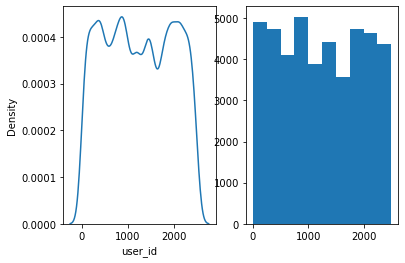

dtype: int64, max: 2499, min: 1, shape uinque: (779,)

item_id


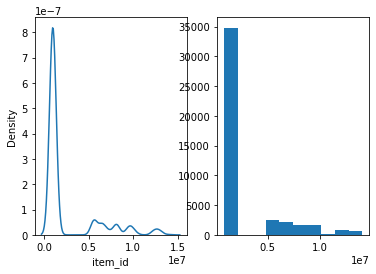

dtype: int64, max: 14106445, min: 819255, shape uinque: (1159,)

manufacturer


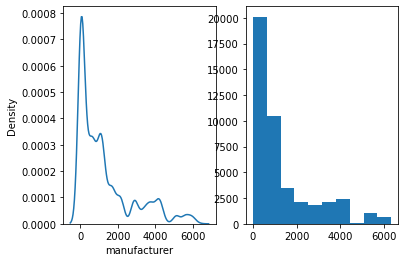

dtype: int64, max: 6331, min: 2, shape uinque: (338,)

department
dtype: object, max: spirits, min: deli, shape uinque: (13,)
unique
['deli' 'drug gm' 'floral' 'grocery' 'meat' 'meat-pckgd' 'misc. trans.'
 'nutrition' 'pastry' 'produce' 'seafood' 'seafood-pckgd' 'spirits']

brand
dtype: object, max: Private, min: National, shape uinque: (2,)
unique
['National' 'Private']

commodity_desc
dtype: object, max: YOGURT, min: APPLES, shape uinque: (138,)

sub_commodity_desc
dtype: object, max: YOGURT NOT MULTI-PACKS, min: ADULT CEREAL, shape uinque: (380,)

curr_size_of_product
dtype: object, max: PT, min:  , shape uinque: (270,)

count_department


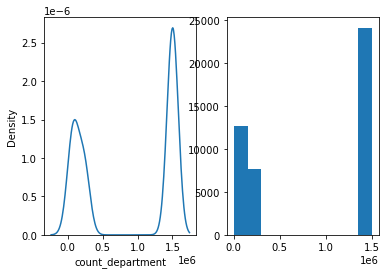

dtype: int64, max: 1503017, min: 1705, shape uinque: (13,)
unique
[   1705    1941    3611    3809    9947   28186   34605   57214   80865
  102746  237021  246423 1503017]

mean_department_sum_price


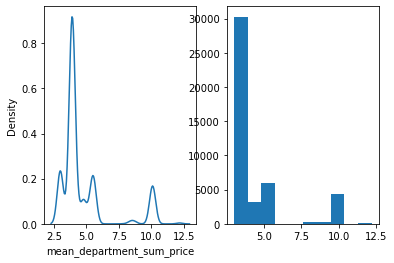

dtype: float64, max: 12.223958944281547, min: 2.9868974900933822, shape uinque: (13,)
unique
[ 2.98689749  3.90114737  4.31551163  4.7705226   5.21156957  5.39701339
  5.54574251  7.87086553  8.39229299  8.6744335  10.09336746 12.14093988
 12.22395894]

mean_brand_sum_price


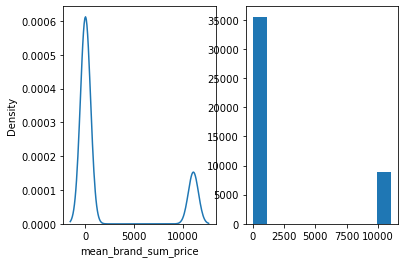

dtype: float64, max: 11074.865385282152, min: 4.728807154784701, shape uinque: (2,)
unique
[4.72880715e+00 1.10748654e+04]

mean_manufacturer_sum_price


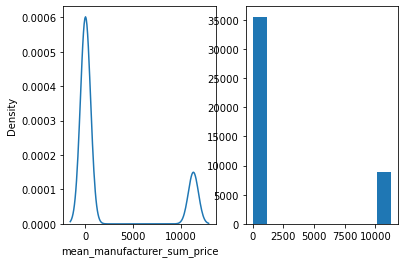

dtype: float64, max: 11286.2429125097, min: 2.0168315018313985, shape uinque: (338,)

count_brand


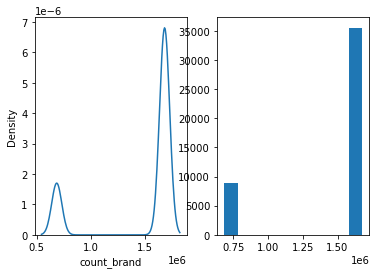

dtype: int64, max: 1679388, min: 683451, shape uinque: (2,)
unique
[ 683451 1679388]

count_manufacturer


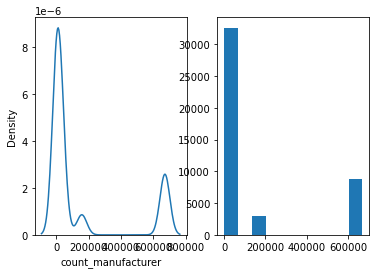

dtype: int64, max: 670644, min: 86, shape uinque: (312,)

age_desc
dtype: object, max: 65+, min: 19-24, shape uinque: (6,)
unique
['19-24' '25-34' '35-44' '45-54' '55-64' '65+']

marital_status_code
dtype: object, max: U, min: A, shape uinque: (3,)
unique
['A' 'B' 'U']

income_desc
dtype: object, max: Under 15K, min: 100-124K, shape uinque: (12,)
unique
['100-124K' '125-149K' '15-24K' '150-174K' '175-199K' '200-249K' '25-34K'
 '250K+' '35-49K' '50-74K' '75-99K' 'Under 15K']

homeowner_desc
dtype: object, max: Unknown, min: Homeowner, shape uinque: (5,)
unique
['Homeowner' 'Probable Owner' 'Probable Renter' 'Renter' 'Unknown']

hh_comp_desc
dtype: object, max: Unknown, min: 1 Adult Kids, shape uinque: (6,)
unique
['1 Adult Kids' '2 Adults Kids' '2 Adults No Kids' 'Single Female'
 'Single Male' 'Unknown']

household_size_desc
dtype: object, max: 5+, min: 1, shape uinque: (5,)
unique
['1' '2' '3' '4' '5+']

kid_category_desc
dtype: object, max: None/Unknown, min: 1, shape uinque: (4,)
uni

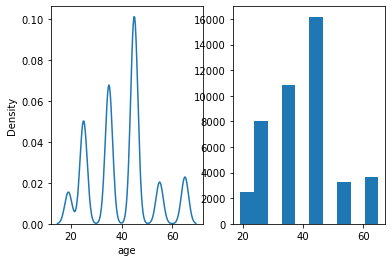

dtype: int32, max: 65, min: 19, shape uinque: (6,)
unique
[19 25 35 45 55 65]

income


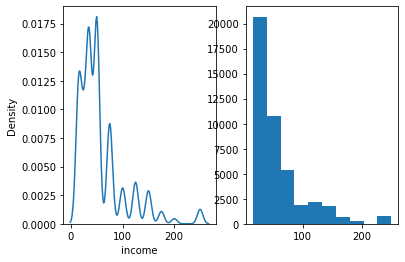

dtype: int32, max: 250, min: 15, shape uinque: (11,)
unique
[ 15  25  35  50  75 100 125 150 175 200 250]

total_item_sales_value


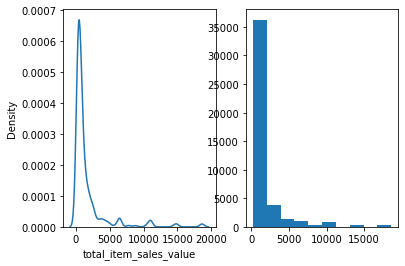

dtype: float64, max: 18606.72000000026, min: 183.73000000000002, shape uinque: (1158,)

total_quantity_value


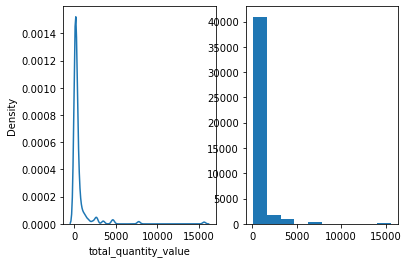

dtype: int64, max: 15612, min: 71, shape uinque: (386,)

item_freq


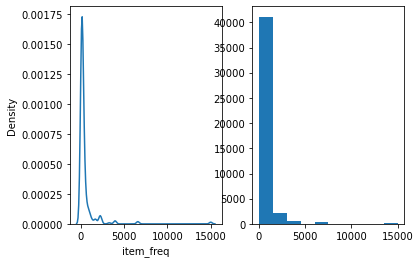

dtype: int64, max: 14988, min: 19, shape uinque: (371,)

total_user_sales_value


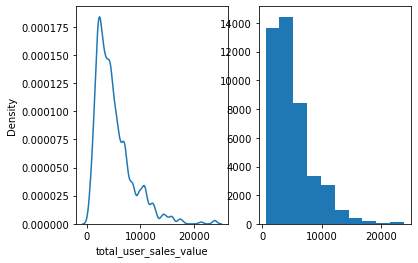

dtype: float64, max: 23805.83000000042, min: 534.8400000000004, shape uinque: (779,)

mean_sales_item_week_day


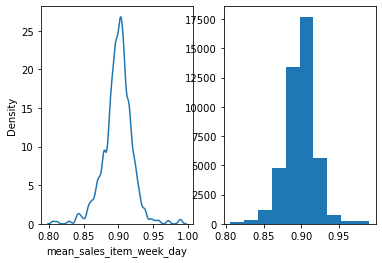

dtype: float64, max: 0.9900486374229547, min: 0.8060928209943532, shape uinque: (779,)

mean_sales_item_month_day


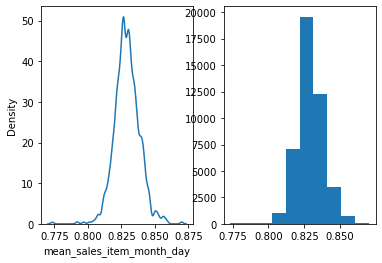

dtype: float64, max: 0.8701049600779455, min: 0.7734799801847538, shape uinque: (779,)

mean_sales_item_quartal


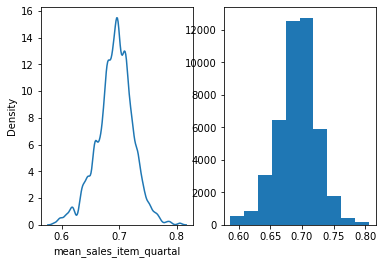

dtype: float64, max: 0.805703108101076, min: 0.5867642574772379, shape uinque: (779,)

mean_quantity_item_week_day


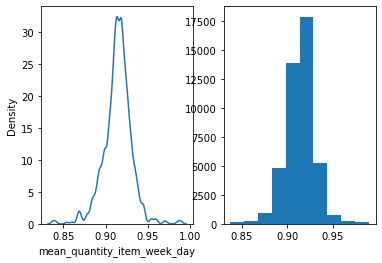

dtype: float64, max: 0.9898230932928357, min: 0.8373552300726578, shape uinque: (779,)

mean_quantity_item_month_day


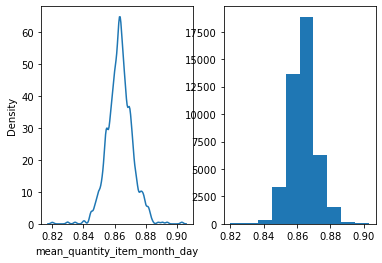

dtype: float64, max: 0.90309411678312, min: 0.8200211433338972, shape uinque: (779,)

mean_quantity_item_quartal


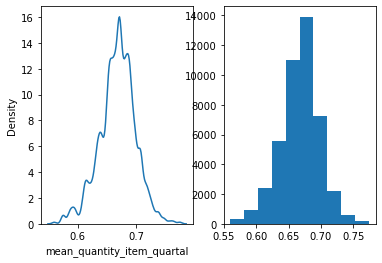

dtype: float64, max: 0.774409586017938, min: 0.560002061508363, shape uinque: (779,)



In [ ]:
print(X_train.info())

for col in X_train.columns:  
    print(col)
    if 'obj' not in str(X_train[col].dtype):
        plt.subplot(1,2,1)
        sns.kdeplot(X_train[col])
        plt.subplot(1,2,2)
        plt.hist(X_train[col])
        plt.show()
    val = X_train[col].values
    try:
        print(f"dtype: {X_train[col].dtype}, max: {np.max(val)}, min: {np.min(val)}, shape uinque: {np.unique(val).shape}")
        if len(np.unique(val)) <= 20:
            print("unique")
            print(np.unique(val))
    except:
        print()
    
    print()

In [ ]:
X_train

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,count_department,mean_department_sum_price,...,total_item_sales_value,total_quantity_value,item_freq,total_user_sales_value,mean_sales_item_week_day,mean_sales_item_month_day,mean_sales_item_quartal,mean_quantity_item_week_day,mean_quantity_item_month_day,mean_quantity_item_quartal
0,149,6533936,2224,grocery,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
1,149,6533936,2224,grocery,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
2,149,6533936,2224,grocery,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
3,149,6533936,2224,grocery,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
4,149,6533936,2224,grocery,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,...,784.54,263,200,10787.63,0.875157,0.826961,0.710440,0.892511,0.861405,0.685262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44397,752,863447,2877,meat,National,BEEF,CHOICE BEEF,,80865,10.093367,...,2855.18,484,397,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893
44398,752,862799,1046,grocery,National,COFFEE,GROUND COFFEE,39 OZ,1503017,3.901147,...,951.99,171,157,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893
44399,752,1138443,3739,deli,National,DELI MEATS,MEAT: TURKEY BULK,,57214,4.770523,...,2168.16,453,444,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893
44400,752,1065167,4099,deli,National,CHEESES,CHEESE: NATURAL BULK,,57214,4.770523,...,343.35,104,104,3401.45,0.905097,0.817768,0.686169,0.918250,0.852335,0.662893


In [ ]:
X_train = pd.get_dummies(X_train, columns = ['department', 'age_desc','marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc'], drop_first=True)

In [ ]:
X_train = X_train.rename(columns={"department_misc. trans.": "department_misc.trans.", "department_drug gm": "department_drug_gm"})

In [ ]:
#X_train['total_user_sales_value'] = np.round(X_train['total_user_sales_value'] / 10, 0) * 10
#-0.025

In [ ]:
cat_feats = X_train.columns[2:].tolist()

cat_feats = [e for e in cat_feats if e not in ('total_item_sales_value', 'sum_sale_quartal', 'total_quantity_value', 'total_user_sales_value', 'mean_sales_item_week_day', 'mean_sales_item_month_day')]
#cat_feats = [e for e in cat_feats if e not in ['total_item_sales_value', 'total_quantity_value', 'total_user_sales_value']]
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'count_department',
 'mean_department_sum_price',
 'mean_brand_sum_price',
 'mean_manufacturer_sum_price',
 'count_brand',
 'count_manufacturer',
 'age',
 'income',
 'item_freq',
 'mean_sales_item_quartal',
 'mean_quantity_item_week_day',
 'mean_quantity_item_month_day',
 'mean_quantity_item_quartal',
 'department_drug_gm',
 'department_floral',
 'department_grocery',
 'department_meat',
 'department_meat-pckgd',
 'department_misc.trans.',
 'department_nutrition',
 'department_pastry',
 'department_produce',
 'department_seafood',
 'department_seafood-pckgd',
 'department_spirits',
 'age_desc_25-34',
 'age_desc_35-44',
 'age_desc_45-54',
 'age_desc_55-64',
 'age_desc_65+',
 'marital_status_code_B',
 'marital_status_code_U',
 'income_desc_125-149K',
 'income_desc_15-24K',
 'income_desc_150-174K',
 'income_desc_175-199K',
 'income_desc_200-249K',
 'income_desc_25-34K',
 'income_desc_250K+',
 'i

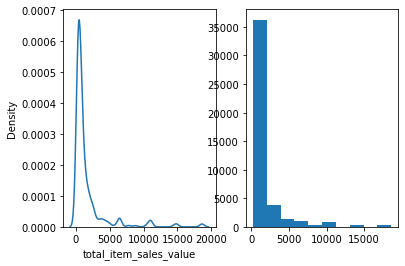

In [ ]:
plt.subplot(1,2,1)
sns.kdeplot(X_train['total_item_sales_value'])
plt.subplot(1,2,2)
plt.hist(X_train['total_item_sales_value'])
plt.show()

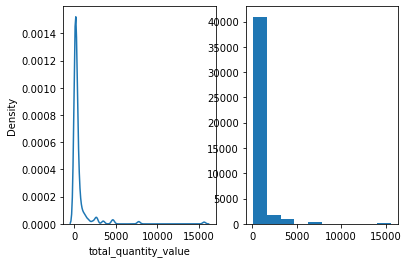

In [ ]:
plt.subplot(1,2,1)
sns.kdeplot(X_train['total_quantity_value'])
plt.subplot(1,2,2)
plt.hist(X_train['total_quantity_value'])
plt.show()

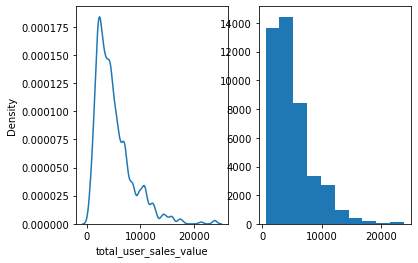

In [ ]:
plt.subplot(1,2,1)
sns.kdeplot(X_train['total_user_sales_value'])
plt.subplot(1,2,2)
plt.hist(X_train['total_user_sales_value'])
plt.show()

## Обучение модели ранжирования

In [ ]:
X_train

,user_id,item_id,manufacturer,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,count_department,mean_department_sum_price,mean_brand_sum_price,...,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
0,149,6533936,2224,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,4.728807,...,0,0,0,1,0,0,0,0,0,1
1,149,6533936,2224,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,4.728807,...,0,0,0,1,0,0,0,0,0,1
2,149,6533936,2224,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,4.728807,...,0,0,0,1,0,0,0,0,0,1
3,149,6533936,2224,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,4.728807,...,0,0,0,1,0,0,0,0,0,1
4,149,6533936,2224,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12OZ/12PK,1503017,3.901147,4.728807,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44397,752,863447,2877,National,BEEF,CHOICE BEEF,,80865,10.093367,4.728807,...,1,0,0,1,0,0,0,0,0,1
44398,752,862799,1046,National,COFFEE,GROUND COFFEE,39 OZ,1503017,3.901147,4.728807,...,1,0,0,1,0,0,0,0,0,1
44399,752,1138443,3739,National,DELI MEATS,MEAT: TURKEY BULK,,57214,4.770523,4.728807,...,1,0,0,1,0,0,0,0,0,1
44400,752,1065167,4099,National,CHEESES,CHEESE: NATURAL BULK,,57214,4.770523,4.728807,...,1,0,0,1,0,0,0,0,0,1


In [ ]:
tr = X_train

In [ ]:
tr['target'] = y_train

In [ ]:
query_groups = tr.groupby("user_id")
group_list = list(query_groups.groups)
train_groups, validation_groups = train_test_split(group_list, test_size = 0.25)

def get_group_with_index(x):
    return query_groups.get_group(x)

train_queries = pd.concat([get_group_with_index(x) for x in train_groups], axis = 0 )
validation_queries =pd.concat( [get_group_with_index(x) for x in validation_groups], axis = 0)

y_train_ = train_queries['target']
y_validation = validation_queries['target']

group_id_train = train_queries['user_id']
group_id_validation = validation_queries['user_id']

non_train_variables = ['target']

X_train_ = train_queries.drop(non_train_variables, axis=1)
X_validation = validation_queries.drop(non_train_variables, axis=1)

validation_pool = Pool(data=X_validation, label=y_validation, cat_features = cat_feats, group_id = group_id_validation)
train_pool = Pool(data=X_train_, label=y_train_, cat_features = cat_feats, group_id = group_id_train)

CatBoostError: Invalid type for cat_feature category for [feature_idx=13]=0.47546443433273283 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [ ]:
from catboost import CatBoost

In [ ]:
param = {'loss_function':'PairLogit',
         'learning_rate':.05,
         'iterations':200,
         'depth':12,
         'use_best_model':True,
         'one_hot_max_size':1,
         'bagging_temperature':.7,
         'max_ctr_complexity':4 }
model = CatBoost(param)
model.fit(train_pool, eval_set=validation_pool,
    logging_level='Silent',
    plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
train_preds = model.predict(X_train)

In [ ]:
cat = CatBoostClassifier(max_depth=10, 
                         n_estimators=1600,
                         learning_rate=0.9,
                         task_type="GPU",
                         devices='0:1',
                         cat_features=cat_feats)

cat.fit(X_train, y_train)

train_preds = cat.predict_proba(X_train)
#Pool

0:	learn: 0.4401727	total: 75.9ms	remaining: 2m 1s
1:	learn: 0.4063212	total: 153ms	remaining: 2m 2s
2:	learn: 0.3973823	total: 229ms	remaining: 2m 2s
3:	learn: 0.3929793	total: 303ms	remaining: 2m
4:	learn: 0.3884518	total: 375ms	remaining: 1m 59s
5:	learn: 0.3842416	total: 452ms	remaining: 2m
6:	learn: 0.3820725	total: 539ms	remaining: 2m 2s
7:	learn: 0.3805584	total: 615ms	remaining: 2m 2s
8:	learn: 0.3793747	total: 686ms	remaining: 2m 1s
9:	learn: 0.3769931	total: 764ms	remaining: 2m 1s
10:	learn: 0.3758946	total: 842ms	remaining: 2m 1s
11:	learn: 0.3743395	total: 916ms	remaining: 2m 1s
12:	learn: 0.3726711	total: 991ms	remaining: 2m
13:	learn: 0.3713059	total: 1.06s	remaining: 2m
14:	learn: 0.3700904	total: 1.14s	remaining: 2m
15:	learn: 0.3693810	total: 1.21s	remaining: 2m
16:	learn: 0.3671518	total: 1.29s	remaining: 2m
17:	learn: 0.3665676	total: 1.37s	remaining: 2m
18:	learn: 0.3657555	total: 1.44s	remaining: 1m 59s
19:	learn: 0.3648438	total: 1.51s	remaining: 1m 59s
20:	learn:

161:	learn: 0.2807023	total: 12.6s	remaining: 1m 51s
162:	learn: 0.2797510	total: 12.7s	remaining: 1m 51s
163:	learn: 0.2796005	total: 12.7s	remaining: 1m 51s
164:	learn: 0.2790645	total: 12.8s	remaining: 1m 51s
165:	learn: 0.2786815	total: 12.9s	remaining: 1m 51s
166:	learn: 0.2782014	total: 13s	remaining: 1m 51s
167:	learn: 0.2779423	total: 13.1s	remaining: 1m 51s
168:	learn: 0.2775499	total: 13.1s	remaining: 1m 51s
169:	learn: 0.2772644	total: 13.2s	remaining: 1m 51s
170:	learn: 0.2769100	total: 13.3s	remaining: 1m 50s
171:	learn: 0.2766457	total: 13.4s	remaining: 1m 50s
172:	learn: 0.2759679	total: 13.4s	remaining: 1m 50s
173:	learn: 0.2755321	total: 13.5s	remaining: 1m 50s
174:	learn: 0.2753920	total: 13.6s	remaining: 1m 50s
175:	learn: 0.2747036	total: 13.7s	remaining: 1m 50s
176:	learn: 0.2742353	total: 13.8s	remaining: 1m 50s
177:	learn: 0.2740706	total: 13.8s	remaining: 1m 50s
178:	learn: 0.2732690	total: 13.9s	remaining: 1m 50s
179:	learn: 0.2731427	total: 14s	remaining: 1m 5

319:	learn: 0.2311496	total: 25s	remaining: 1m 40s
320:	learn: 0.2309229	total: 25.1s	remaining: 1m 40s
321:	learn: 0.2307188	total: 25.2s	remaining: 1m 40s
322:	learn: 0.2305564	total: 25.3s	remaining: 1m 39s
323:	learn: 0.2305053	total: 25.4s	remaining: 1m 39s
324:	learn: 0.2304423	total: 25.4s	remaining: 1m 39s
325:	learn: 0.2302691	total: 25.5s	remaining: 1m 39s
326:	learn: 0.2299844	total: 25.6s	remaining: 1m 39s
327:	learn: 0.2299052	total: 25.7s	remaining: 1m 39s
328:	learn: 0.2291059	total: 25.7s	remaining: 1m 39s
329:	learn: 0.2289989	total: 25.8s	remaining: 1m 39s
330:	learn: 0.2284060	total: 25.9s	remaining: 1m 39s
331:	learn: 0.2279053	total: 26s	remaining: 1m 39s
332:	learn: 0.2278304	total: 26s	remaining: 1m 39s
333:	learn: 0.2275801	total: 26.1s	remaining: 1m 39s
334:	learn: 0.2271422	total: 26.2s	remaining: 1m 38s
335:	learn: 0.2266076	total: 26.3s	remaining: 1m 38s
336:	learn: 0.2262133	total: 26.4s	remaining: 1m 38s
337:	learn: 0.2258543	total: 26.4s	remaining: 1m 38s

477:	learn: 0.1964939	total: 37.3s	remaining: 1m 27s
478:	learn: 0.1964272	total: 37.4s	remaining: 1m 27s
479:	learn: 0.1962982	total: 37.5s	remaining: 1m 27s
480:	learn: 0.1962293	total: 37.6s	remaining: 1m 27s
481:	learn: 0.1962057	total: 37.6s	remaining: 1m 27s
482:	learn: 0.1960994	total: 37.7s	remaining: 1m 27s
483:	learn: 0.1960489	total: 37.8s	remaining: 1m 27s
484:	learn: 0.1958266	total: 37.9s	remaining: 1m 27s
485:	learn: 0.1958053	total: 38s	remaining: 1m 27s
486:	learn: 0.1957460	total: 38s	remaining: 1m 26s
487:	learn: 0.1953019	total: 38.1s	remaining: 1m 26s
488:	learn: 0.1949718	total: 38.2s	remaining: 1m 26s
489:	learn: 0.1949441	total: 38.3s	remaining: 1m 26s
490:	learn: 0.1948577	total: 38.4s	remaining: 1m 26s
491:	learn: 0.1948071	total: 38.4s	remaining: 1m 26s
492:	learn: 0.1947738	total: 38.5s	remaining: 1m 26s
493:	learn: 0.1947275	total: 38.6s	remaining: 1m 26s
494:	learn: 0.1946786	total: 38.6s	remaining: 1m 26s
495:	learn: 0.1945336	total: 38.7s	remaining: 1m 2

635:	learn: 0.1742318	total: 49.6s	remaining: 1m 15s
636:	learn: 0.1740207	total: 49.7s	remaining: 1m 15s
637:	learn: 0.1735223	total: 49.8s	remaining: 1m 15s
638:	learn: 0.1734304	total: 49.9s	remaining: 1m 14s
639:	learn: 0.1733409	total: 49.9s	remaining: 1m 14s
640:	learn: 0.1732289	total: 50s	remaining: 1m 14s
641:	learn: 0.1731178	total: 50.1s	remaining: 1m 14s
642:	learn: 0.1727313	total: 50.2s	remaining: 1m 14s
643:	learn: 0.1726512	total: 50.2s	remaining: 1m 14s
644:	learn: 0.1726318	total: 50.3s	remaining: 1m 14s
645:	learn: 0.1725011	total: 50.4s	remaining: 1m 14s
646:	learn: 0.1718257	total: 50.5s	remaining: 1m 14s
647:	learn: 0.1717700	total: 50.6s	remaining: 1m 14s
648:	learn: 0.1715366	total: 50.6s	remaining: 1m 14s
649:	learn: 0.1714482	total: 50.7s	remaining: 1m 14s
650:	learn: 0.1713723	total: 50.8s	remaining: 1m 14s
651:	learn: 0.1712917	total: 50.9s	remaining: 1m 13s
652:	learn: 0.1712445	total: 50.9s	remaining: 1m 13s
653:	learn: 0.1710145	total: 51s	remaining: 1m 1

794:	learn: 0.1531151	total: 1m 1s	remaining: 1m 2s
795:	learn: 0.1530634	total: 1m 2s	remaining: 1m 2s
796:	learn: 0.1529969	total: 1m 2s	remaining: 1m 2s
797:	learn: 0.1529367	total: 1m 2s	remaining: 1m 2s
798:	learn: 0.1528121	total: 1m 2s	remaining: 1m 2s
799:	learn: 0.1527398	total: 1m 2s	remaining: 1m 2s
800:	learn: 0.1527153	total: 1m 2s	remaining: 1m 2s
801:	learn: 0.1525876	total: 1m 2s	remaining: 1m 2s
802:	learn: 0.1525074	total: 1m 2s	remaining: 1m 2s
803:	learn: 0.1524811	total: 1m 2s	remaining: 1m 1s
804:	learn: 0.1523690	total: 1m 2s	remaining: 1m 1s
805:	learn: 0.1523395	total: 1m 2s	remaining: 1m 1s
806:	learn: 0.1522452	total: 1m 2s	remaining: 1m 1s
807:	learn: 0.1521937	total: 1m 2s	remaining: 1m 1s
808:	learn: 0.1518831	total: 1m 2s	remaining: 1m 1s
809:	learn: 0.1518155	total: 1m 3s	remaining: 1m 1s
810:	learn: 0.1517889	total: 1m 3s	remaining: 1m 1s
811:	learn: 0.1516390	total: 1m 3s	remaining: 1m 1s
812:	learn: 0.1514987	total: 1m 3s	remaining: 1m 1s
813:	learn: 

953:	learn: 0.1391897	total: 1m 14s	remaining: 50.4s
954:	learn: 0.1388179	total: 1m 14s	remaining: 50.3s
955:	learn: 0.1385974	total: 1m 14s	remaining: 50.2s
956:	learn: 0.1385778	total: 1m 14s	remaining: 50.1s
957:	learn: 0.1383465	total: 1m 14s	remaining: 50.1s
958:	learn: 0.1383268	total: 1m 14s	remaining: 50s
959:	learn: 0.1381598	total: 1m 14s	remaining: 49.9s
960:	learn: 0.1381536	total: 1m 14s	remaining: 49.8s
961:	learn: 0.1378862	total: 1m 15s	remaining: 49.8s
962:	learn: 0.1375627	total: 1m 15s	remaining: 49.7s
963:	learn: 0.1373896	total: 1m 15s	remaining: 49.6s
964:	learn: 0.1372917	total: 1m 15s	remaining: 49.5s
965:	learn: 0.1371682	total: 1m 15s	remaining: 49.5s
966:	learn: 0.1371561	total: 1m 15s	remaining: 49.4s
967:	learn: 0.1371278	total: 1m 15s	remaining: 49.3s
968:	learn: 0.1371076	total: 1m 15s	remaining: 49.2s
969:	learn: 0.1369659	total: 1m 15s	remaining: 49.1s
970:	learn: 0.1369378	total: 1m 15s	remaining: 49.1s
971:	learn: 0.1363000	total: 1m 15s	remaining: 4

1107:	learn: 0.1270550	total: 1m 26s	remaining: 38.4s
1108:	learn: 0.1267668	total: 1m 26s	remaining: 38.3s
1109:	learn: 0.1267511	total: 1m 26s	remaining: 38.2s
1110:	learn: 0.1267458	total: 1m 26s	remaining: 38.2s
1111:	learn: 0.1266929	total: 1m 26s	remaining: 38.1s
1112:	learn: 0.1266205	total: 1m 26s	remaining: 38s
1113:	learn: 0.1264593	total: 1m 26s	remaining: 37.9s
1114:	learn: 0.1264497	total: 1m 26s	remaining: 37.8s
1115:	learn: 0.1264456	total: 1m 27s	remaining: 37.8s
1116:	learn: 0.1262702	total: 1m 27s	remaining: 37.7s
1117:	learn: 0.1262585	total: 1m 27s	remaining: 37.6s
1118:	learn: 0.1262510	total: 1m 27s	remaining: 37.5s
1119:	learn: 0.1262061	total: 1m 27s	remaining: 37.4s
1120:	learn: 0.1261965	total: 1m 27s	remaining: 37.4s
1121:	learn: 0.1261764	total: 1m 27s	remaining: 37.3s
1122:	learn: 0.1261531	total: 1m 27s	remaining: 37.2s
1123:	learn: 0.1261325	total: 1m 27s	remaining: 37.1s
1124:	learn: 0.1261105	total: 1m 27s	remaining: 37s
1125:	learn: 0.1260930	total: 1m

1262:	learn: 0.1171918	total: 1m 38s	remaining: 26.3s
1263:	learn: 0.1171508	total: 1m 38s	remaining: 26.2s
1264:	learn: 0.1171246	total: 1m 38s	remaining: 26.2s
1265:	learn: 0.1169676	total: 1m 38s	remaining: 26.1s
1266:	learn: 0.1169569	total: 1m 38s	remaining: 26s
1267:	learn: 0.1169334	total: 1m 38s	remaining: 25.9s
1268:	learn: 0.1166009	total: 1m 39s	remaining: 25.8s
1269:	learn: 0.1164815	total: 1m 39s	remaining: 25.8s
1270:	learn: 0.1163406	total: 1m 39s	remaining: 25.7s
1271:	learn: 0.1163369	total: 1m 39s	remaining: 25.6s
1272:	learn: 0.1163227	total: 1m 39s	remaining: 25.5s
1273:	learn: 0.1163085	total: 1m 39s	remaining: 25.5s
1274:	learn: 0.1162408	total: 1m 39s	remaining: 25.4s
1275:	learn: 0.1162229	total: 1m 39s	remaining: 25.3s
1276:	learn: 0.1162055	total: 1m 39s	remaining: 25.2s
1277:	learn: 0.1161708	total: 1m 39s	remaining: 25.1s
1278:	learn: 0.1161605	total: 1m 39s	remaining: 25.1s
1279:	learn: 0.1159747	total: 1m 39s	remaining: 25s
1280:	learn: 0.1159671	total: 1m

1417:	learn: 0.1077822	total: 1m 50s	remaining: 14.2s
1418:	learn: 0.1077686	total: 1m 50s	remaining: 14.2s
1419:	learn: 0.1076926	total: 1m 51s	remaining: 14.1s
1420:	learn: 0.1074983	total: 1m 51s	remaining: 14s
1421:	learn: 0.1074266	total: 1m 51s	remaining: 13.9s
1422:	learn: 0.1074090	total: 1m 51s	remaining: 13.8s
1423:	learn: 0.1074008	total: 1m 51s	remaining: 13.8s
1424:	learn: 0.1073697	total: 1m 51s	remaining: 13.7s
1425:	learn: 0.1073471	total: 1m 51s	remaining: 13.6s
1426:	learn: 0.1072103	total: 1m 51s	remaining: 13.5s
1427:	learn: 0.1072027	total: 1m 51s	remaining: 13.5s
1428:	learn: 0.1071805	total: 1m 51s	remaining: 13.4s
1429:	learn: 0.1071762	total: 1m 51s	remaining: 13.3s
1430:	learn: 0.1071697	total: 1m 51s	remaining: 13.2s
1431:	learn: 0.1070090	total: 1m 52s	remaining: 13.1s
1432:	learn: 0.1068777	total: 1m 52s	remaining: 13.1s
1433:	learn: 0.1067113	total: 1m 52s	remaining: 13s
1434:	learn: 0.1067040	total: 1m 52s	remaining: 12.9s
1435:	learn: 0.1066800	total: 1m

1571:	learn: 0.0990207	total: 2m 3s	remaining: 2.19s
1572:	learn: 0.0990113	total: 2m 3s	remaining: 2.12s
1573:	learn: 0.0989968	total: 2m 3s	remaining: 2.04s
1574:	learn: 0.0989776	total: 2m 3s	remaining: 1.96s
1575:	learn: 0.0989591	total: 2m 3s	remaining: 1.88s
1576:	learn: 0.0989257	total: 2m 3s	remaining: 1.8s
1577:	learn: 0.0989118	total: 2m 3s	remaining: 1.72s
1578:	learn: 0.0988987	total: 2m 3s	remaining: 1.65s
1579:	learn: 0.0988920	total: 2m 3s	remaining: 1.57s
1580:	learn: 0.0988253	total: 2m 3s	remaining: 1.49s
1581:	learn: 0.0988184	total: 2m 3s	remaining: 1.41s
1582:	learn: 0.0988104	total: 2m 4s	remaining: 1.33s
1583:	learn: 0.0987619	total: 2m 4s	remaining: 1.25s
1584:	learn: 0.0987542	total: 2m 4s	remaining: 1.18s
1585:	learn: 0.0987434	total: 2m 4s	remaining: 1.1s
1586:	learn: 0.0985340	total: 2m 4s	remaining: 1.02s
1587:	learn: 0.0984968	total: 2m 4s	remaining: 940ms
1588:	learn: 0.0984534	total: 2m 4s	remaining: 862ms
1589:	learn: 0.0984423	total: 2m 4s	remaining: 7

In [ ]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'brand', 'commodity_desc',
       'sub_commodity_desc', 'curr_size_of_product', 'total_item_sales_value',
       'total_quantity_value', 'item_freq', 'total_user_sales_value',
       'department_drug_gm', 'department_floral', 'department_grocery',
       'department_meat', 'department_meat-pckgd', 'department_misc.trans.',
       'department_nutrition', 'department_pastry', 'department_produce',
       'department_seafood', 'department_seafood-pckgd', 'department_spirits',
       'age_desc_19-24', 'age_desc_25-34', 'age_desc_35-44', 'age_desc_45-54',
       'age_desc_55-64', 'age_desc_65+', 'marital_status_code_A',
       'marital_status_code_B', 'marital_status_code_U',
       'income_desc_100-124K', 'income_desc_125-149K', 'income_desc_15-24K',
       'income_desc_150-174K', 'income_desc_175-199K', 'income_desc_200-249K',
       'income_desc_25-34K', 'income_desc_250K+', 'income_desc_35-49K',
       'income_desc_50-74K', 'income_desc_75-99

In [ ]:
for e in ['total_item_sales_value', 'total_quantity_value', 'total_user_sales_value', 'mean_sales_item_week_day', 'mean_sales_item_month_day']:
    if e not in cat_feats:
        cat_feats.append(e)
X_train[cat_feats] = X_train[cat_feats].astype('category')

lgb = LGBMClassifier(objective='binary',
                     max_depth=12,
                     n_estimators=1600,
                     learning_rate=0.9,
                     categorical_column=cat_feats)
#n_estimators 500->1000
#learning_rate 0.05->0.5
#+0.22

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [ ]:
np.shape(X_train)

(44402, 72)

In [ ]:
df_ranker_predict = df_ranker_train.copy()

In [ ]:
train_preds

array([[7.03714974e-08, 9.99999930e-01],
       [7.03714974e-08, 9.99999930e-01],
       [7.03714974e-08, 9.99999930e-01],
       ...,
       [9.99999966e-01, 3.35748752e-08],
       [9.99999966e-01, 3.35748752e-08],
       [9.99999969e-01, 3.14110723e-08]])

In [ ]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
#df_ranker_predict['proba_item_purchase'] = train_preds

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [ ]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[1082185, 1041796, 1115576, 978974, 1081189, 8..."
1,7,"[898867, 918771, 5589978, 12487505, 1038184, 8..."


## Eval matching on test dataset

In [ ]:
result_eval_ranker

,user_id,actual
0,1,"[1082185, 1041796, 1115576, 978974, 1081189, 8..."
1,7,"[898867, 918771, 5589978, 12487505, 1038184, 8..."
2,8,"[1082185, 822241, 901062, 904023, 5569230, 948..."
3,13,"[1132771, 995242, 5978656, 980727, 856060, 131..."
4,17,"[1082185, 923746, 5569471, 857849, 832678, 740..."
...,...,...
774,2494,"[5978656, 12781924, 9859236, 889700, 10356658,..."
775,2496,"[6534178, 1082185, 981760, 1106523, 899624, 97..."
776,2497,"[951590, 1127025, 938700, 1137775, 1018740, 55..."
777,2498,"[1082185, 989824, 1072843, 16208725, 6773190, ..."


In [ ]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 400 ms


In [ ]:
result_eval_ranker = result_eval_ranker.merge(all_predictions_bpr, left_on='user_id', right_on='user_id')

In [ ]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.31065468549422276), ('bpr', 0.14916559691912792)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [ ]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [ ]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [ ]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.31065468549422276)
('reranked_own_rec', 0.307060333761232)
('bpr', 0.14916559691912792)


precision@5 >= 0.25

0.18975903614457496

0.1941767068273059

('reranked_own_rec', 0.21405622489959528)
('own_rec', 0.2122489959839334)
('bpr', 0.11425702811244898)

# смотрим на метрики выше и сравниваем что с ранжированием и без, добавляем фичи и то же смотрим

# Оценка на тесте для выполнения курсового проекта

In [ ]:
df_test = pd.read_csv('../data/retail_test1.csv')
#df_transactions = pd.read_csv('../data/transaction_data.csv')

In [ ]:
df_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [ ]:
result_test = df_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [ ]:
result_test['reranked_own_rec'] = result_test['user_id'].apply(lambda x: rerank(x))
#result_test['own_rec'] = result_test['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
#result_test = result_test.merge(all_predictions_bpr, left_on='user_id', right_on='user_id')

In [ ]:
print(*sorted(calc_precision(result_test, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1834464043419274)


d:\git\GB-Рекомендательные системы\Курсовой\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера